For my assignment, I will teaching users how to create a bigram language model for text generation and a simple character Recurrent Neural Network (RNN) and comparing the quality of output to that of text generated by a neural network using pytorch. To determine which model is better, I will be checking for the percentage of sentences were gramatically correct. I will also be checking for training speed of each model to compare, if one model is significantly slower than the other to train, if the tradeoff in quality is worth it.

All of our dataset (books) we use are from Project Gutenberg (http://www.gutenberg.org/ebooks/). I have scrubbed out the top and bottom portions such as the index/table of contents and references to Gutenberg Project in order to get a more accurate model. I do not claim ownership of any of the books/.txt files in this directory. If there is a problem with me scrubbing out those portions of text, please let me know and I will reupload this project with the originals.

For our weighting function, we will be using f(x) = log_10(x + 1) for frequency normalization as we would be working with very large data sets.

First, we import all the necessary libraries needed to run our bigram code:

In [64]:
import sys
import language_check
import collections
import random
import pickle
import math
import re
import time

Now, with this setup, we need to start collecting data, which in this case, would be text files of several books that are available online.

In [65]:
def load_raw(titles):
    books = []
    for book in titles:
        with open(book, 'r') as f:
            books.append(f.read())
    return books

With the acquired raw data, we now need to clean up the inputs so that we have a list of list of words. We need to get rid of empty lines, random white spaces, etc.

In [66]:
def clean(books):
    for i in range(len(books)):
        books[i] = list(filter(lambda s: len(s) > 0, re.split(r'[\s"]', books[i])))
    return books

Now that we have clean text to work with, we can create our Markov chain data structure. We will be using a nested defaultdict that takes care of how often a word appears in the document. Using the counts, we will then iterate through every bigram and find the max occurence/frequency to calculate new weights to each word. After we train our Markov chain model, we should be able to store that nested dictionary into a file where we can reload our trained data if needed.

For generation, we will randomly choose a bigram/key from our outer dictionary (each one will have equal weight), and then we would chain off more words to append to that sentence based on the weights we calculated until we reach a sentence ending punctuation.

In [67]:
class MarkovChain:
    def __init__(self):
        self.tree = collections.defaultdict(lambda: collections.defaultdict(int))
        self.final_weights = collections.defaultdict(lambda: collections.defaultdict(int))

    ##Training function, grabs raw counts of each bigram
    def add_words(self, text):
        for i in range(len(text) - 2):
            key_1 = text[i]
            key_2 = text[i+1]
            value = text[i+2]
            self.tree[(key_1, key_2)][value] += 1
            
    ##Weighting function, used to generate new sentences based on normalized frequency
    def reevaluate_weights(self):
        for keys in self.tree:
            for val in self.tree[keys]:
                self.final_weights[keys][val] = math.log10(self.tree[keys][val] + 1)

    def generate(self):
        EOS = [".", "!", "?"]
        if len(self.tree) == 0:
            return ""
        sentence = random.choice([(k1,k2) for (k1,k2) in self.tree if k1[0].isupper()])
        current_bigram = sentence
        sentence = sentence[0] +" " + sentence[1]
        #If our sentence is longer than 50 words, just cut it
        limit = 50
        counter = 0
        while True:
            if counter == 50:
                return sentence
            if current_bigram not in self.tree:
                return sentence
            if sentence[-1] in EOS:
                return sentence
            weights = self.final_weights[current_bigram]
            p = []
            values = []
            for word in weights:
                values.append(word)
                p.append(weights[word])
            #random.choices returns a list, so we only want the first element in that list
            word = random.choices(values, weights = p)[0]
            current_bigram = (current_bigram[1], word)
            sentence += " " + word
            counter += 1
            

After creating this data structure, all we need to do for the bigram portion is to create a wrapper function that runs all our code and times the training portion.

In [68]:
def main_mark():
    #Add more book titles here as you 
    titles = ['1984.txt', 'animal_farm.txt', 'illiad.txt', 'odyssey.txt']
    books = load_raw(titles)
    books = clean(books)
    mk = MarkovChain()
    t0 = time.time()
    for book in books:
        mk.add_words(book)
    mk.reevaluate_weights()
    t1 = time.time()
    tool = language_check.LanguageTool('en-US')
    running_count = 0
    for i in range(150):
        mk_sentences = mk.generate()
        if tool.check(mk_sentences):
            running_count += 1
        if i%10 == 0:
            print(str(i)+ "th sentence: " + mk_sentences)
    accuracy = (1 - running_count/150)
    print("It took " + str(t1 - t0) + " seconds to finish training the markov chain and produced an accuracy of " + str(accuracy))

main_mark()

0th sentence: Astyoche a noble father, and sallied forth, Ulysses leading the way they had entered the din of combat, or Jove will be much of it.
10th sentence: In somewhat the same gesture with his long spear.
20th sentence: Jove devised evil against me.
30th sentence: Scheria and went back when the housekeeper give him good advice of which, however, he is son neither to right nor ruth?
40th sentence: Apheidas, who is on the round of the two valiant heroes, Thrasymedes and Antilochus, valiant warriors; all did he go to bed, Here comes a candle to light you to drink, it dried up and shake themselves like a simpleton.
50th sentence: Achilles as may escape.
60th sentence: Africa, or the cruel knife in the liver below the elbow, and the sea; the moon also at fighting from chariots, and the animals into the vestibule of the dead.
70th sentence: Minerva vouchsafed me victory.
80th sentence: Honour him then and there: Jove, however, sent the chiefest of their oars, for the wrongs you have fa

After running this code, we see that most of the time is spent actually generating the sentences, but we see that about half of the generated sentences are actually grammatically correct. Of course, this grammar accuracy will probably be better if we used a trigram (or higher) model, but as we learned in class, the more words you add to the keys to our markov chain, the more closely our text will be to the original, so our strings wouldn't be as unique. Now, we will create a neural network that will do the same thing. I believe that the training will take longer, but I expect the quality of the output should be better (assuming we run enough epochs for training).

For this portion, I received a lot of help from this youtube video, where the engineer went over how to use Tensorflow and how to create a simple character RNN. 

We will be using pytorch for our framework to create a character RNN, so let us import the following:

In [69]:
import torch
import torch.nn as nn
#Variable is a wrapper around tensor objects retains all operations that
#occur on that tensor
from torch.autograd import Variable

For this neural network, we want to take all the dataset and combine them into one list, and then we want to break down the input into chracters. This is done so that we can essentially create a probability array that will help us determine which character comes next in the sequence.

In [70]:
titles = ['1984.txt', 'animal_farm.txt', 'illiad.txt', 'odyssey.txt']
books = ""
for book in titles:
    with open(book, 'r') as f:
        books += f.read() + "\n"
            
characters = sorted(list(set(books)))
c2i = {c: i for i, c in enumerate(characters)}
i2c = {i: c for i, c in enumerate(characters)}

print(c2i)
print(i2c)

{'\n': 0, ' ': 1, '!': 2, '"': 3, '&': 4, "'": 5, '(': 6, ')': 7, '*': 8, '+': 9, ',': 10, '-': 11, '.': 12, '0': 13, '1': 14, '2': 15, '3': 16, '4': 17, '5': 18, '6': 19, '7': 20, '8': 21, '9': 22, ':': 23, ';': 24, '=': 25, '?': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 'E': 31, 'F': 32, 'G': 33, 'H': 34, 'I': 35, 'J': 36, 'K': 37, 'L': 38, 'M': 39, 'N': 40, 'O': 41, 'P': 42, 'Q': 43, 'R': 44, 'S': 45, 'T': 46, 'U': 47, 'V': 48, 'W': 49, 'X': 50, 'Y': 51, 'Z': 52, '[': 53, ']': 54, 'a': 55, 'b': 56, 'c': 57, 'd': 58, 'e': 59, 'f': 60, 'g': 61, 'h': 62, 'i': 63, 'j': 64, 'k': 65, 'l': 66, 'm': 67, 'n': 68, 'o': 69, 'p': 70, 'q': 71, 'r': 72, 's': 73, 't': 74, 'u': 75, 'v': 76, 'w': 77, 'x': 78, 'y': 79, 'z': 80}
{0: '\n', 1: ' ', 2: '!', 3: '"', 4: '&', 5: "'", 6: '(', 7: ')', 8: '*', 9: '+', 10: ',', 11: '-', 12: '.', 13: '0', 14: '1', 15: '2', 16: '3', 17: '4', 18: '5', 19: '6', 20: '7', 21: '8', 22: '9', 23: ':', 24: ';', 25: '=', 26: '?', 27: 'A', 28: 'B', 29: 'C', 30: 'D', 31: 'E',

We will now set up create the recurrent neural network class that pytorch has. The nn api can be found here: http://pytorch.org/docs/master/nn.html. A quick explanation of each field can be found above each line.

In [71]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers):
        super(RNN, self).__init__()
        #Size of our feature vector (all unique characters that appear in our text)
        self.input_size = input_size
        #Number of nodes in your hidden layer
        self.hidden_size = hidden_size
        #Size of output vector
        self.output_size = output_size
        #Number of recurrent layers in the neural network
        self.n_layers = n_layers
        #Encoder is used to take input and convert it to a context vector
        self.encoder = nn.Embedding(input_size, hidden_size)
        #GRU is essentially the "middle step" between the encoding process and the decoding
        #process.
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        #Decoder's job is to take the internal representation of the output and convert it
        #back to a readable sentence (into characters)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def init_hidden(self):
        #Initializes the hidden layer of the neural network, represented by n x m matrix,
        #where n is the number of layers and m is the size of the hidden layer
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
    
    def forward(self, input_tensor, hidden):
        #Function run by pytorch that will be run for each epoch (iteration of training)
        #Converts our input vector that's usable by the GRU
        input_encoded = self.encoder(input_tensor.view(1, -1))
        encoded_output, hidden = self.gru(input_encoded.view(1, 1, -1), hidden)
        decoded_output = self.decoder(encoded_output.view(1, -1))
        return decoded_output, hidden

To train our neural network, we need to take small chunks of our original text in order to establish a probability matrix that will allow the network to determine what the next character should be. Essentially, if our chunk of text is "ABCDEF", then our initial input vector would be "ABCDE" and our target vector that we want our network to achieve would be "BCDEF". However, keep in mind, too small of chunk size will cause our training time to take forever, but too large of chunk size will give us innacurate/meaningless results.

In [72]:
#Change accordingly
chunk_size = 100

def get_random_chunk():
    start = random.randint(0, len(books) - chunk_size)
    end = start + chunk_size + 1
    return books[start:end]

print(get_random_chunk())

oft and flung it down, smashing Epicles' four-crested helmet
so that the bones of his head were crush


Each random chunk we generate must be turned into a "tensor", which is just a fancy way of calling our input a list of longs (each character in the input must be converted to their corresponding index that they appear in the feature vector).

In [73]:
def char_to_tensor(text):
    tensor = torch.zeros(len(text)).long()
    for i in range(len(text)):
        tensor[i] = c2i[text[i]]
    return Variable(tensor)

print(char_to_tensor("ABCDElmnop"))

Variable containing:
 27
 28
 29
 30
 31
 66
 67
 68
 69
 70
[torch.LongTensor of size 10]



Now that we have our helper functions needed to create the training vectors, let's actually create a function that gives us the input vector and the target vector:

In [74]:
def get_training_data():
    chunk = get_random_chunk()
    #Everything but the last element
    input_vector = chunk[:-1]
    input_tensor = char_to_tensor(input_vector)
    #Everything but the first element
    target_vector = chunk[1:]
    target_tensor = char_to_tensor(target_vector)
    return input_tensor, target_tensor

Now that we have many of the helper functions written to provide data into our RNN, we now need to create an evaluate function that takes in a initial vector to train on, along with how many characters we want our model to output. We also pass in a temperature parameter, which in the context of a character RNN, is a value between 0 and 1 and, when set extremely low, makes the model's predictions "conservative" in that it would make predictions that are correct but made outputs less interesting (lots of repeating outputs, etc.), but you can raise the value to make the model "confident" and take more risks, but at the cost of higher volumes of errors. 

This evaluate function is to take the input string and, using the trained probability distribution, predict the next character. 

In [75]:
def evaluate(starting_string, temperature):
    #Initialize base configurations to start building up hidden layer
    hidden_array = rnn.init_hidden()
    input_tensor = char_to_tensor(starting_string)
    predicted_output = starting_string
    
    #Feed input to hidden layer
    for p in range(len(predicted_output) - 1):
        #We don't care about the output, as this is part of the setup
        #phase, so any output up to this point is meaningless
        _, hidden_array = rnn(input_tensor[p], hidden_array)
    target = input_tensor[-1]
    
    #Generate characters until you reach the end of sentence. Hard-set a max
    #limit on the sentence so that the loop doesn't take forever (ie temperature
    #causes uninteresting and looping outputs)
    EOS = ["!", ".", "?"]
    counter = 0
    while predicted_output[-1] not in EOS:
        #Change limit here
        if counter >= 100:
            return predicted_output
        #Pass in the target to generate next letter
        output, hidden_array = rnn(target, hidden_array)
        
        output_distribution = output.data.view(-1).div(temperature).exp()
        predicted_character = i2c[torch.multinomial(output_distribution, 1)[0]]
        #Add the character to the final output
        predicted_output += predicted_character
        target = char_to_tensor(predicted_character)
    return predicted_output

Now, we need to write the training function:

In [76]:
def train(inp, target):
    hidden_array = rnn.init_hidden()
    rnn.zero_grad()
    calculated_loss = 0
    
    for i in range(chunk_size):
        output, hidden_array = rnn(inp[i], hidden_array)
        calculated_loss += criterion(output, target[i])
        
    calculated_loss.backward()
    rnn_opt.step()
    
    return calculated_loss.data[0]/chunk_size

Now that we have all our functions/classes written, let's put them all together.

In [88]:
#lr is the learning rate, if the model makes an error, this is how much
#our probability is shifted by
lr = 0.005
#epochs is the number of iterations
number_epochs = 3000
hidden_size = 100
n_layers = 3
chunk_size = 200

rnn = RNN(len(feature), hidden_size, len(feature), n_layers)
rnn_opt = torch.optim.Adam(rnn.parameters(), lr=lr)
#Calculates how much error the model has experienced
criterion = nn.CrossEntropyLoss()
time_start = time.time()
plot_loss = []
running_total = 0

for iteration in range(number_epochs):
    #* operation unpacks the object/function call, kind of like
    #dereferencing in C
    current_loss = train(*get_training_data())
    running_total += current_loss
    if iteration%20 == 0:
        print("["+str(iteration)+ "th epoch: loss = " + str(current_loss) + "]")
        print("[Time since start: " + str(time.time() - time_start) + "]")
        print(evaluate("Th", 0.8 ))
        print("\n")
    
    if iteration%10 == 0:
        plot_loss.append(running_total/10)
        running_total = 0

[0th epoch: loss = 4.412333374023437]
[Time since start: 0.44237709045410156]
Th5gId?


[20th epoch: loss = 3.2843426513671874]
[Time since start: 9.052558183670044]
Thhfp   eav omneoaeeo  o -i esba
r u rv g thor npseee ec  .


[40th epoch: loss = 3.4070904541015623]
[Time since start: 18.71027684211731]
TheoC coet eole
nen o s sotuasetsyylieu,ttsp p not ohdtd n hrfeti nrya ortapo e  i,esattto eoednt.


[60th epoch: loss = 2.681922607421875]
[Time since start: 28.056803941726685]
Th renes
 c ost  hin she scmeu a in heeAr
aosy otmes hiar hes wtir ttint .


[80th epoch: loss = 2.664523010253906]
[Time since start: 38.34944486618042]
The arnis fben ton egpes hvan e a  hehe o telsar anaaak hOmtoiIt oreum homgobropre ola an amin
irdere on aopheginan heuf ban winAovege on ne Ir eAmceftok tire os tae htot
ftas twis om ir han crhahd hin Dheyr.


[100th epoch: loss = 2.59959716796875]
[Time since start: 49.27732300758362]
Thg uri mo roah; sor he or ilereune as cagauys re se
she ra oor are 
vome

[580th epoch: loss = 1.8924320983886718]
[Time since start: 279.09805178642273]
The cullound choulney men I nohe.


[600th epoch: loss = 1.9908256530761719]
[Time since start: 287.3945119380951]
The he pall be all he alrom Bunners Apen the spily rom sield mould coll yating of the band all had goment a hel in the and is dear kelles for four in congu bep plae and and to bost the hacris hound shinf that Larse he and nou.


[620th epoch: loss = 1.857195587158203]
[Time since start: 295.95518016815186]
Thas shake day ok the fort huves to thought hef a and son you haast hinghuld and thile dame had and fave
Jove the in ecous come.


[640th epoch: loss = 1.959637908935547]
[Time since start: 304.5219941139221]
The hering that the matTo I the T Ocompat he It of to hen out of Precmitting the greverer and dany
ane were whemO T--
T-- proptenen to whephen- betulitcower the ceOt An's in come the the he to they to the granger chearoneriSther the T he trost and spater who the THeir trone, for wory now

[1040th epoch: loss = 1.9015524291992187]
[Time since start: 492.2172210216522]
There intalk to theaghter of the selnated, and
algo the had and to head in the mept oven there
sard the keet what Jove
and fet holler and houm lechaid the hald of the some into hen the hous to Oll neveleadling handound we the peal house laive will on the with there Avent, and fain the Cy a shild feats to whom will he tell and theard the would so solloundingul; the other, vark and Danded, and the melm exet the was coured and the had down vay and some that meen gatles, to the gods.


[1060th epoch: loss = 1.820958709716797]
[Time since start: 501.92414116859436]
Then ee the when preta in the sic, the goce to intuans sing evear the be Crose intering
of d2he
cuxersiar.


[1080th epoch: loss = 1.894901580810547]
[Time since start: 511.57055401802063]
The he Hether, for'f thatwece had mat go been tod be piae the gresed, the faced, wime the lead him gody may, down filled wouch of for and
of Tanded of Jetors of sou

[1420th epoch: loss = 1.7365354919433593]
[Time since start: 677.9642598628998]
Their werrates ove the frepturpear with he mere his seased daughter on rang-cil was he speales.


[1440th epoch: loss = 1.8844252014160157]
[Time since start: 687.4005329608917]
The by the fioth no good was could neiss a long, and with she sain, the fall were after all he and in the fall women mean
of stiod which Aen
were unpered on he hould over my Trojansert for have the father the to kirs to be and samming the prony.


[1460th epoch: loss = 1.9234956359863282]
[Time since start: 696.2488241195679]
There my with AOwhile, beging side and with trulse in on their had would not had
cows, who on it in the strouse in twit sinece hold in scould and days the ment.


[1480th epoch: loss = 1.763748321533203]
[Time since start: 707.6624851226807]
The hanskice he wamman his head amand waterselging he sameson for hand mages the sent for his Trojans, are bath fath her had you to keates sood hame of the fief one the ama

[1960th epoch: loss = 1.604410400390625]
[Time since start: 921.9506349563599]
The sowt mast his sprase that eemeding she lest may ourse and his his would among the lined heart the
pres in here up, sons through Achilles the my sheesied dluemation.


[1980th epoch: loss = 1.7675453186035157]
[Time since start: 930.2225339412689]
The would a singered, and were Jove custect the sin borcuty, snow with the spipe, but her obing of the being back of it of the at strent an ming retion.


[2000th epoch: loss = 1.7463755798339844]
[Time since start: 939.4799339771271]
The horm first we me meemon the was fight to singed roteder, spew that ano very wento and the by cesomed rest the evesssed with canth on these cheam and the singed of they hay that that at the
midliw a could have
mongers thought a soddeless.


[2020th epoch: loss = 1.9420523071289062]
[Time since start: 947.585333108902]
That also lite leming the leing his some.


[2040th epoch: loss = 1.6016024780273437]
[Time since start: 955.858

[2560th epoch: loss = 1.755670166015625]
[Time since start: 1206.4864358901978]
Thersed to he chaled care the deat the beed sheon time in the with he and geot also their with a greation in to the much and was runded him of the pucting see dourrest with some.


[2580th epoch: loss = 1.6856048583984375]
[Time since start: 1216.5459849834442]
The rone impusing nor have he fishe, and ground, and as he woll of Pares of home him no had so one and a chave for you wiside of actoleous as from the boce of murling that he he gods have
you.


[2600th epoch: loss = 1.8334100341796875]
[Time since start: 1227.7673480510712]
That cried and lot are you look of and saus strolly you thought us the suil cown, and Plorvear- and Aet the front and the said old in his convest where as the boke to furst and said hard nother and soon one
the fould the some the suires.


[2620th epoch: loss = 1.7146849060058593]
[Time since start: 1240.428550004959]
There we min be amongly in theremen-on he pelemach host it hem

Now that we have trained our model, we need to save it!

In [91]:
torch.save(rnn, 'trained.pt')
#To load it, we can simply run
#rnn = torch.load('trained.pt)

/anaconda2/envs/py36/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Some funny observations I've noticed after running this code several times:

1) Changing the number of layers didn't changes my output by a noticeable amount

2) It actually used the names Achaean several times, which shows the power of learning

3) During one run, it found the use of "---" repeated several times to be acceptable behavior, which I promply killed after the 5th output.

Now, we see that, although many of these sentences are not gramatically correct (and actually pretty nonsense), they do yield more interesting sentences than that of the bigram we used earlier. 

With this, we can conclude that for the purpose of generating text, neural nets are probably not the way to go. They take a long time to train and the outputs aren't that great without some human touching up.

Just for interesting stats, we can plot out calculated loss:

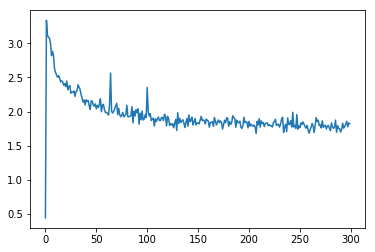

In [96]:
import matplotlib.pyplot as plt
import matplotlib.ticker

plt.figure()
plt.plot(plot_loss)
plt.show()